C:\Users\yesda\AppData\Local\Temp\ipykernel_26432\1959669053.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  usol[i][j] = heat_eq_exact_solution(x[i], t[j])


Compiling model...
Building feed-forward neural network...

'build' took 0.114513 s




c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.465986 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.78e-03, 1.92e-02, 3.50e-01]    [4.95e-03, 1.92e-02, 3.50e-01]    []  
1000      [6.65e-04, 4.07e-04, 1.51e-04]    [4.22e-04, 4.07e-04, 1.51e-04]    []  
2000      [1.01e-04, 1.42e-05, 1.30e-05]    [6.13e-05, 1.42e-05, 1.30e-05]    []  
3000      [5.11e-05, 9.67e-06, 7.12e-06]    [2.96e-05, 9.67e-06, 7.12e-06]    []  
4000      [3.97e-05, 6.82e-06, 5.28e-06]    [2.37e-05, 6.82e-06, 5.28e-06]    []  
5000      [2.57e-05, 6.64e-06, 8.91e-06]    [1.57e-05, 6.64e-06, 8.91e-06]    []  
6000      [7.75e-05, 1.32e-05, 4.11e-05]    [6.89e-05, 1.32e-05, 4.11e-05]    []  
7000      [1.67e-05, 2.77e-06, 1.85e-06]    [1.10e-05, 2.77e-06, 1.85e-06]    []  
8000      [1.22e-05, 2.01e-06, 1.44e-06]    [8.58e-06, 2.01e-06, 1.44e-06]    []  
9000      [1.01e-05, 1.56e-06, 1.13e-06]    [7.37e-06, 1.56e-06, 1.13e-06]    []  
10000     [8.64e-06, 1.43e-06, 1.2

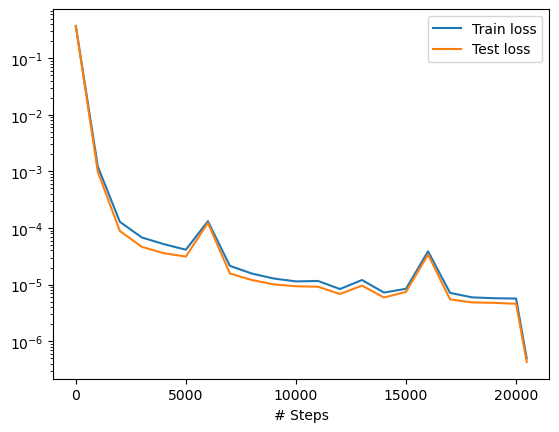

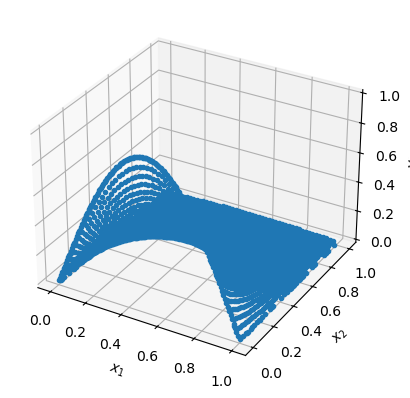

Mean residual: 0.000486001
L2 relative error: 0.0005091128170319298


In [7]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np


def heat_eq_exact_solution(x, t):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)


def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you dont have one):
gen_exact_solution()


def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Backend pytorch
# import torch
# Backend paddle
# import paddle


C = dde.Variable(2.0)


def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - C * dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )
    # Backend pytorch
    # return (
    #     dy_t
    #     - C * dy_xx
    #     + torch.exp(-x[:, 1:])
    #     * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    # )
    # Backend paddle
    # return (
    #     dy_t
    #     - C * dy_xx
    #     + paddle.exp(-x[:, 1:])
    #     * (paddle.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * paddle.sin(np.pi * x[:, 0:1]))
    # )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C
)
variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)